# CS4487 - Machine Learning
# Lecture 3a - Linear Classifiers
## Dr. Antoni B. Chan
### Dept. of Computer Science, City University of Hong Kong

# Outline
1. Discriminative linear classifiers
2. Logistic regression
3. Support vector machines (SVM)

In [1]:
# setup
%matplotlib inline
import IPython.core.display         # setup output image format (Chrome works best)
IPython.core.display.set_matplotlib_formats("svg")
import matplotlib.pyplot as plt
import matplotlib
from numpy import *
from sklearn import *
from scipy import stats

# Classification with Generative Model
- Steps to build a classifier
  1. Collect training data (features $x$ and class labels $y$)
  2. Learn class-conditional distribution (CCD), $p(x|y)$.
  3. Use Bayes' rule to calculate class probability, $p(y|x)$.
- **Note:** the data is used to learn the CCD -- the classifier is secondary.
  - Density estimation is an "ill-posed" problem -- which density to use?  how much data is needed?

- Advice from Vladimir Vapnik (inventor of SVM):
> When solving a problem, try to avoid solving a more general problem as an intermediate step.

- **Discriminative solution**
  - Solve for the classifier $p(y|x)$ directly!

- Terminology
  - **"Discriminative"** - learn to directly discriminate the classes apart using the features.
  - **"Generative"** - learn model of how the features are generated from different classes.

# Linear Classifier
- **Setup**
  - Observation (feature vectors) $x\in \mathbb{R}^d$
  - Class $y \in \{-1, +1\}$
- **Goal**: given a feature vector $x$, predict its class $y$.
  - Calculate a _linear function_ of the feature vector $x$.
    - $f(x) = w^T x + b = \sum_{j=1}^d w_j x_j + b$
      - $w\in \mathbb{R}^d$ are the weights of the linear function.
  - Predict from the value:
    - if $f(x) > 0$ then predict Class $y=1$
    - if $f(x) < 0$ then predict Class $y=-1$
    - Equivalently, $y = \mathrm{sign}(f(x))$

# Geometric Interpretation
- The linear classifier separates the features space into 2 _half-spaces_
  - corresponding to feature values belonging to Class +1 and Class -1
  - the class boundary is normal to $w$.
    - also called the _separating hyperplane_.

  - Example: $w = \begin{bmatrix}2\\1\end{bmatrix}$, $b=0$

In [2]:
def drawplane(w, b, wlabel=None, poscol=None, negcol=None):
    # w^Tx + b = 0
    # w0 x0 + w1 x1 + b = 0
    # x1 = -w0/w1 x0 - b / w1

    # the line
    x0 = linspace(-10,10)
    x1 = -w[0]/w[1] * x0 - b / w[1]
    
    
    # fill positive half-space or neg space
    if (poscol):
        polyx = [x0[0], x0[-1], x0[-1], x0[0]]
        polyy = [x1[0], x1[-1], x1[0], x1[0]]
        plt.fill(polyx, polyy, poscol, alpha=0.2)
    
    if (negcol):
        polyx = [x0[0], x0[-1], x0[0], x0[0]]
        polyy = [x1[0], x1[-1], x1[-1], x1[0]]
        plt.fill(polyx, polyy, negcol, alpha=0.2)
        
    # plot line
    plt.plot(x0, x1, 'k-', lw=2)

    # the w
    if (wlabel):
        xp = array([0, -b/w[1]])
        xpw = xp+w
        plt.arrow(xp[0], xp[1], w[0], w[1], width=0.01)
        plt.text(xpw[0]-0.5, xpw[1], wlabel)
    

In [3]:
linclass = plt.figure()
w = array([2, 1])
b = 0;

drawplane(w, b, '$w$', 'b', 'r')

# a few points
plt.plot([2.2,4,3], [-2,2,-1], 'bx')
plt.plot([-2.2,-4,-3], [2,1,-1], 'ro')

plt.text(-1.8,4, "$f(x) = 0$", fontsize=12)
plt.text(4, 3.5, "$f(x)>0$\nclass +1", ha="right", fontsize=12)
plt.text(-4, -3.5, "$f(x)<0$\nclass -1", fontsize=12)

plt.xlabel('feature $x_1$'); plt.ylabel('feature $x_2$')
plt.axis([-5, 5, -5, 5]); plt.grid(True)
plt.axes().set_aspect('equal')
plt.close()

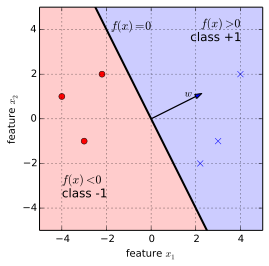

In [4]:
linclass

# Separating Hyperplane
- In a $d$-dimensional feature space, the parameters are $w\in\mathbb{R}^d$.
- The equation $w^Tx + b = 0$ defines a $(d-1)$-dim. linear surface:
  - for $d=2$, $w$ defines a 1-D line.
  - for $d=3$, $w$ defines a 2-D plane.
  - ...
  - in general, we call it a hyperplane.


# Learning the classifier
- How to set the classifier parameters $(w, b)$?
  - Learn them from training data!
- Classifiers differ in the objectives used to learn the parameters $(w,b)$.
  - We will look at two examples:
    - logistic regression
    - support vector machine (SVM)

# Logistic regression
- Use a probabilistic approach
- Need to map the function values $f(x) = w^Tx + b$ to probability values between 0 and 1.
  - _sigmoid_ function maps from real number to interval [0,1]
  - $\sigma(z) = \frac{1}{1+e^{-z}}$

In [5]:
z = linspace(-5,5)
sigz = 1/(1+exp(-z))

sigmoidplot = plt.figure(figsize=(5,3))

plt.plot(z,sigz, 'b-')

plt.xlabel('z'); plt.ylabel('$\sigma(z)$')
plt.axis([-5, 5, 0, 1]); plt.grid(True)
plt.close()

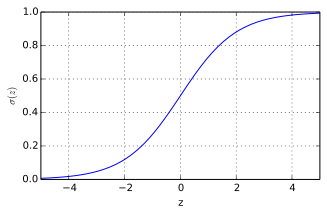

In [6]:
sigmoidplot

- Given a feature vector $x$, the probability of a class is:
  - $p(y=+1|x) = \sigma( f(x) )$
  - $p(y=-1|x) = 1-\sigma( f(x) )$
- Note: here we are directly modeling the class posterior probability!
  - not the class-conditional $p(x|y)$

In [7]:
x = linspace(-10,10, 100)
w = 2.0
b = -4.0
f = w*x+b
sf = 1/(1+exp(-f))
midx = -b/w

lrexample = plt.figure(figsize=(6,3))

a1, = plt.plot(x,sf, 'b-')
a2, = plt.plot(x,1-sf, 'r-')
a3, = plt.plot([midx, midx], [0.0,1.2], 'k--')

plt.arrow(midx-0.1,1.05,-1.8,0,width=0.002)
plt.arrow(midx+0.1,1.05,1.8,0,width=0.002)
plt.text(midx+0.2,1.10,"Class +1")
plt.text(midx-0.2,1.10,"Class -1", horizontalalignment='right')
plt.legend((a1,a2,a3), ("p(y=+1|x)", "p(y=-1|x)") + ('decision boundary',), 0, framealpha=1, fontsize='medium')
plt.title('class posterior p(y|x)');
plt.xlabel('feature x'); plt.ylabel('probability')
plt.axis([-7, 7, 0, 1.2]); plt.grid(True)
plt.close()

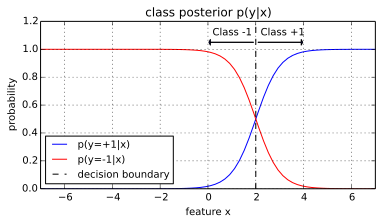

In [8]:
lrexample

# Learning the parameters
- Given training data $\{x_i,y_i\}_{i=1}^N$, learn the function parameters $(w,b)$ using maximum likelihood estimation.
- maximize the likelihood of the data $\{x_i,y_i\}$:
  $$(w^*,b^*) = \mathop{\mathrm{argmax}}_{w,b} \sum_{i=1}^N \log p(y_i|x_i)$$

- to prevent _overfitting_, add a prior distribution on $w$.
  - assume Gaussian distribution on $w$ with variance $1/C$
  $$(w^*,b^*) = \mathop{\mathrm{argmax}}_{w,b} \log p(w) + \sum_{i=1}^N \log p(y_i|x_i)$$

- Equivalently, 
  $$(w^*,b^*) = \mathop{\mathrm{argmin}}_{w,b} \frac{1}{C} w^Tw + \sum_{i=1}^N \log (1+\exp(-y_i (w^T x_i+b)))$$
- the first term is the _regularization term_
  - keeps entries in $w$ from getting too large.
  - $C$ is the regularization _hyperparameter_
    - larger $C$ value allow large values in $w$.
    - smaller $C$ value discourage large values in $w$.
- the second term is the _data-fit term_
    - wants to make the parameters $(w,b)$ to well fit the data.

- **no closed-form solution**
  - use an iterative optimization algorithm to find the optimal solution
  - e.g. _gradient descent_ - step downhill in each iteration.
    - $w \leftarrow w - \eta \frac{d E}{dw}$
    - where $E$ is the objective function
    - $\eta$ is the _learning rate_ (how far to step in each iteration).

# Example: Iris Data

In [9]:
# define class labels, plot markers, and feature labels
markers   = ('ro', 'gs'); lines = ('r-', 'g-')
featnames = ("petal length", "sepal width")
xr = [ arange(2.5,7,0.05) , arange(1.5, 4, 0.05) ]
axbox = [2.5, 7, 1.5, 4]

# load iris dataset from scikit-learn
iris = datasets.load_iris()    

# get the indices of the 2 classes of interest.
inds = squeeze( (iris.target==1) | (iris.target==2) )

# get the targets
target     = iris.target[inds]
classnums  = unique(target)
classnames = ('versicolor (1)', 'virginica (2)')
# make a colormap for viewing classes
mycmap = matplotlib.colors.LinearSegmentedColormap.from_list('mycmap', ["#FF0000", "#FFFFFF", "#00FF00"])

# extract the data (each row is a sample)
# inds extracts rows, while
#  (2,1) extracts the two dimensions
# ix_ is a magic function to select a subarray
data = iris.data[ix_(inds, (2,1))]
print data.shape

(100, 2)


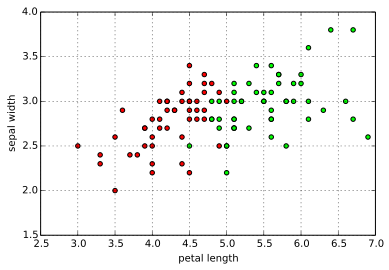

In [10]:
# start a new figure in matplotlib
plt.figure()   

# plot data using scatter plot
plt.scatter(data[:,0], data[:,1], c=target, cmap=mycmap)

# label the axes
plt.xlabel(featnames[0]); plt.ylabel(featnames[1])  
# set plot axes (xmin, xmax, ymin, ymax)
plt.axis(axbox); plt.grid(True);

In [11]:
# randomly split data into 50% train and 50% test set
trainX, testX, trainY, testY = \
  cross_validation.train_test_split(data, target, 
  train_size=0.5, test_size=0.5, random_state=4487)

print trainX.shape
print testX.shape

(50, 2)
(50, 2)


In [12]:
# learn logistic regression classifier
# (C is a regularization hyperparameter)
logreg = linear_model.LogisticRegression(C=100)
logreg.fit(trainX, trainY)

print "w =", logreg.coef_
print "b =", logreg.intercept_

w = [[ 4.87521863 -0.61512848]]
b = [-21.67874573]


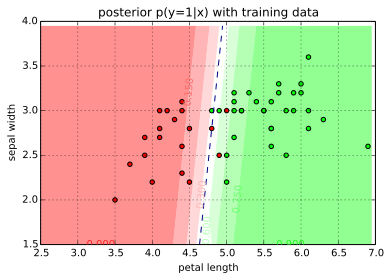

In [13]:
# make a grid for calculating the posterior, 
#  then form into a big [N,2] matrix
xgrid0, xgrid1 = meshgrid(xr[0], xr[1])
allpts = c_[xgrid0.ravel(), xgrid1.ravel()]

# calculate the posterior probability
post = logreg.predict_proba(allpts)
# extract the posterior for class 2, and reshape into a grid
post1 = post[:,1].reshape(xgrid0.shape)

plt.figure()
# contour plot of the posterior and decision boundary
CS = plt.contourf(xr[0], xr[1], post1, cmap=mycmap, alpha=0.5)
plt.clabel(CS, inline=1, fontsize=10)
plt.contour(xr[0], xr[1], post1, levels=[0.5], linestyles='dashed')

# show training data
plt.scatter(trainX[:,0], trainX[:,1], c=trainY, cmap=mycmap)
plt.axis(axbox); plt.grid(True);
plt.xlabel(featnames[0]); plt.ylabel(featnames[1])
plt.title('posterior p(y=1|x) with training data');

In [14]:
# predict from the model
predY = logreg.predict(testX)

# calculate accuracy
Ncorrect = sum(testY==predY)
acc      = mean(testY==predY)
print "number correct =", Ncorrect
print "test accuracy =", acc

number correct = 46
test accuracy = 0.92


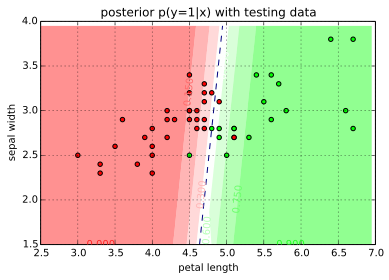

In [15]:
plt.figure()
# contour plot of the posterior and decision boundary
CS = plt.contourf(xr[0], xr[1], post1, cmap=mycmap, alpha=0.5)
plt.clabel(CS, inline=1, fontsize=10)
plt.contour(xr[0], xr[1], post1, levels=[0.5], linestyles='dashed')

# show testing data
plt.scatter(testX[:,0], testX[:,1], c=testY, cmap=mycmap)
plt.axis(axbox); plt.grid(True);
plt.xlabel(featnames[0]); plt.ylabel(featnames[1])
plt.title('posterior p(y=1|x) with testing data');

# Selecting the regularization hyperparameter
- the regularization hyperparameter $C$ has a big effect on the decision boundary and the accuracy.
- How to set the value of $C$?

In [16]:
lrC = plt.figure(figsize=(8,6))

allC = [10000,100, 10, 1,0.01, 0.0001]
for (myCind,myC) in enumerate(allC):
    logreg = linear_model.LogisticRegression(C=myC)
    logreg.fit(trainX, trainY)
    
    # predict from the model
    predY = logreg.predict(testX)

    # calculate accuracy
    Ncorrect = sum(testY==predY)
    acc      = mean(testY==predY)
    
    # make a grid for calculating the posterior, 
    #  then form into a big [N,2] matrix
    xgrid0, xgrid1 = meshgrid(xr[0], xr[1])
    allpts = c_[xgrid0.ravel(), xgrid1.ravel()]

    # calculate the posterior probability
    post = logreg.predict_proba(allpts)
    # extract the posterior for class 2, and reshape into a grid
    post1 = post[:,1].reshape(xgrid0.shape)

    plt.subplot(2,3,myCind+1)
    
    # contour plot of the posterior and decision boundary
    CS = plt.contourf(xr[0], xr[1], post1, cmap=mycmap, alpha=0.5)
    plt.contour(xr[0], xr[1], post1, levels=[0.5], linestyles='dashed')

    # show training data
    plt.scatter(trainX[:,0], trainX[:,1], c=trainY, cmap=mycmap)
    plt.axis([2.5, 7, 1.5, 4]); plt.grid(True);
    plt.title('C='+str(myC)+"; acc="+str(acc));
    plt.gca().xaxis.set_ticklabels([])
    plt.gca().yaxis.set_ticklabels([])
plt.close()

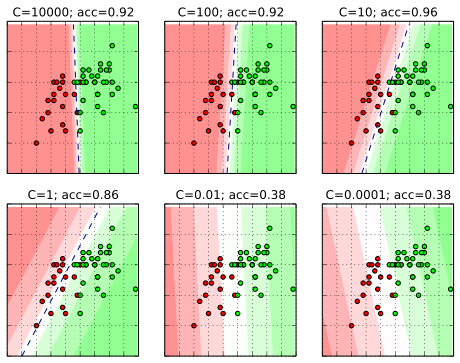

In [17]:
lrC

# Cross-validation
- Use _cross-validation_ on the training set to select the best value of $C$.
  - Split the data into batches of training and validation data.
  - Try a range of $C$ values on each split.
  - Pick the value that works best over all splits.

<center><img src="lecture3/10_fold_cv.png" width="500px"/></center>

- **Procedure**
  1. select a range of $C$ values to try
  2. Repeat $K$ times
    1. Split the training set into training data and validation data
    2. Learn a classifier for each value of $C$
    3. Record the accuracy on the validation data for each $C$
  3. Select the value of $C$ that has the highest average accuracy over all $K$ folds.
  4. Retrain the classifier using all data and the selected $C$.

- scikit-learn already has built-in `cross_validation` module.
- for logistic regression, use _LogisticRegressionCV_ class

In [18]:
# learn logistic regression classifier usinc CV
#  Cs is an array of possible C values
#  cv is the number of folds
logreg = linear_model.LogisticRegressionCV(Cs=logspace(-4,4,20), cv=5)
logreg.fit(trainX, trainY)

print "w=", logreg.coef_
print "b=", logreg.intercept_

# predict from the model
predY = logreg.predict(testX)

# calculate accuracy
Ncorrect = sum(testY==predY)
acc      = mean(testY==predY)
print "test accuracy=", acc

w= [[ 4.61911642  0.72396452]]
b= [-24.24716674]
test accuracy= 0.9


# Which C was selected?

C =  [ 4.2813324]


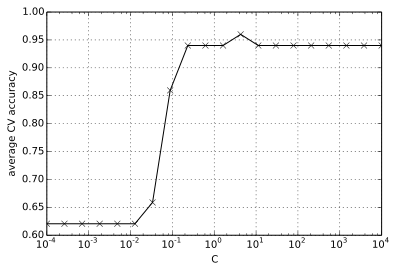

In [19]:
print "C = ", logreg.C_

# calculate the average score for each C
avgscores = mean(logreg.scores_[2],0)  # 2 is the class
plt.figure()
plt.semilogx(logreg.Cs_, avgscores, 'kx-')
plt.xlabel('C'); plt.ylabel('average CV accuracy')
plt.grid(True);

# Multi-class classification
- So far, we have only learned a classifier for 2 classes (+1, -1)
  - called a **binary classifier**
- For more than 2 classes, split the problem up into several binary classifier problems.
  - **1-vs-rest** 
    - _Training:_ for each class, train a classifier for that class versus the other classes.  
      - For example, if there are 3 classes, then train 3 binary classifiers:  1 vs {2,3}; 2 vs {1,3}; 3 vs {1,2}
    - _Prediction:_ calculate probability for each binary classifier.  Select the class with highest probability.

# Example on 3-class Iris data

In [20]:
# define class labels, plot markers, and feature labels
markers   = ('ro', 'gs', 'bv'); lines = ('r-', 'g-', 'b-')
featnames = ("petal length", "sepal width")
xr = [ arange(0.8,7,0.05) , arange(1.5, 4.5, 0.05) ]
axbox = [0.8, 7, 1.5, 4.5]

# load iris dataset from scikit-learn
iris = datasets.load_iris()    

# get the targets
target     = iris.target
classnums  = unique(target)
classnames = ('setosa (0)', 'versicolor (1)', 'virginica (2)')

# make a colormap for viewing classes
mycmap = matplotlib.colors.LinearSegmentedColormap.from_list('mycmap', ["#FF0000", "#00FF00", "#0000FF"])

data = iris.data[:, (2,1)]
print data.shape

(150, 2)


In [21]:
# randomly split data into 50% train and 50% test set
trainX, testX, trainY, testY = \
  cross_validation.train_test_split(data, target, 
  train_size=0.5, test_size=0.5, random_state=4487)

print trainX.shape
print testX.shape

(75, 2)
(75, 2)


In [22]:
# learn logistic regression classifier
logreg = linear_model.LogisticRegression(C=10)
logreg.fit(trainX, trainY)

# now contains 3 hyperplanes and 3 bias terms (one for each class)
print "w=", logreg.coef_
print "b=", logreg.intercept_

# predict from the model
predY = logreg.predict(testX)

# calculate accuracy
Ncorrect = sum(testY==predY)
acc      = mean(testY==predY)
print "test accuracy=", acc

w= [[-3.09131694  2.52132269]
 [ 0.06064355 -1.58022283]
 [ 3.35076433 -3.48981157]]
b= [ 0.73591801  3.79651516 -6.36532274]
test accuracy= 0.973333333333


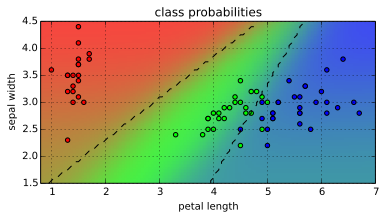

In [23]:
# make a grid for calculating the posterior, 
#  then form into a big [N,2] matrix
xgrid0, xgrid1 = meshgrid(xr[0], xr[1])
allpts = c_[xgrid0.ravel(), xgrid1.ravel()]

# predict probabilities
Z = logreg.predict_proba(allpts)
P = logreg.predict(allpts)

# use probabilities as RGB color
ZZ = Z.reshape((len(xr[1]), len(xr[0]), 3))

plt.figure()
plt.imshow(ZZ, origin='lower', extent=axbox, interpolation='nearest', alpha=0.75)

plt.contour(xr[0], xr[1], P.reshape(xgrid0.shape), levels=[0,1,2], linestyles='dashed', colors='black')

# show training data
plt.scatter(trainX[:,0], trainX[:,1], c=trainY, cmap=mycmap)
plt.axis([0.8, 7, 1.5, 4.5]); 
plt.grid(True);
plt.xlabel(featnames[0]); plt.ylabel(featnames[1])
plt.title('class probabilities');

# Logistic Regression Summary
- **Classifier:**
  - linear function $f(x) = w^Tx + b$
  - Given a feature vector $x$, the probability of a class is:
    - $p(y=+1|x) = \sigma( f(x) )$
    - $p(y=-1|x) = 1-\sigma( f(x) )$
    - _sigmoid_ function: $\sigma(z) = \frac{1}{1+e^{-z}}$
- **Training:**
  - Maximize the likelihood of the training data.
  - Use regularization to prevent overfitting.
    - Use cross-validation to pick the regularization hyperparameter $C$.

- **Classification:**
  - Given a new sample $x^*$:
    - pick class with highest probability $p(y|x^*)$:
      - $y^* = \begin{cases}+1, p(y=+1|x^*)>p(y=-1|x^*) \\ -1, \mathrm{otherwise}\end{cases}$
    - alternatively, just use $f(x^*)$
      - $y^* = \begin{cases}+1, f(x^*)>0 \\ -1, \mathrm{otherwise}\end{cases} = \mathrm{sign}(f(x_*))$